# Assignment 2.

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdataanalysis2020/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday March 30th, 2020 at 23:55. Hand in your files via [`http://peergrade.io`](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 6 days to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Sunday April 5th, 2020 at 23:55. (The reason I'm asking you to do the peer evaluations on the sunday is that I want you to be able to enjoy the easter break fully.)

## Part 1: Questions to text and lectures.

A) Please answer my questions to the Segal and Heer paper we read during lecture 7 and 8.

* What is the *Oxford English Dictionary's* defintion of a narrative?
* What is your favorite visualization among the examples in section 3? Explain why in a few words.
* What's the point of Figure 7?
* Use Figure 7 to find the most common design choice within each category for the Visual narrative and Narrative structure (the categories within visual narrative are 'visual structuring', 'highlighting', etc).
* Check out Figure 8 and section 4.3. What is your favorite genre of narrative visualization? Why? What is your least favorite genre? Why?


B) Also please answer the questions to my talk on [explanatory data visualization](https://www.youtube.com/watch?v=yHKYMGwefso)

* What are the three key elements to keep in mind when you design an explanatory visualization?
* In the video I talk about (1) *overview first*,  (2) *zoom and filter*,  (3) *details on demand*. 
  - Go online and find a visualization that follows these principles (don't use one from the video). 
  - Explain how it does achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.
* Explain in your own words: How is explanatory data analysis different from exploratory data analysis?

In [304]:
import numpy as np
import pandas as pd
import folium
import imageio
import matplotlib
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from graphviz import Source
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [305]:
crimedata = pd.read_csv("../../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
crimedata.Date = pd.to_datetime(crimedata.Date)
crimedata['Hour'] = pd.to_datetime(crimedata.Time).dt.hour
crimedata['DayOfWeek'] = crimedata.Date.dt.dayofweek
crimedata['Month'] = crimedata.Date.dt.month
crimedata['Minutes'] = pd.to_datetime(crimedata.Time).dt.minute
crimedata['Year'] = crimedata.Date.dt.year
crimedata['X'] = crimedata['X'].astype(float)
crimedata['Y'] = crimedata['Y'].astype(float)

In [235]:
crimedata.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Hour,Month,Minutes,Year
0,110308742,MISSING PERSON,FOUND PERSON,4,2011-04-15,16:00,TARAVAL,LOCATED,0 Block of CRESPI DR,-122.476328,37.719687,POINT (-122.476327815126 37.7196874952717),11030874275000,16,4,0,2011
1,90316914,WARRANTS,WARRANT ARREST,3,2009-03-26,12:28,SOUTHERN,"ARREST, BOOKED",1000 Block of MARKET ST,-122.411340,37.781271,POINT (-122.411339562557 37.7812707434494),9031691463010,12,3,28,2009
2,130132311,SECONDARY CODES,DOMESTIC VIOLENCE,4,2013-02-15,02:00,PARK,"ARREST, BOOKED",CASTRO ST / MARKET ST,-122.435188,37.762670,POINT (-122.435187699349 37.7626702770872),13013231115200,2,2,0,2013
3,80052833,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",1,2008-01-15,20:13,MISSION,"ARREST, CITED",VALENCIA ST / 16TH ST,-122.421886,37.764918,POINT (-122.421886357981 37.7649178909424),8005283365016,20,1,13,2008
4,70535770,SECONDARY CODES,DOMESTIC VIOLENCE,5,2007-05-26,18:10,MISSION,"ARREST, BOOKED",2800 Block of FOLSOM ST,-122.413935,37.751693,POINT (-122.413935404044 37.7516932889916),7053577015200,18,5,10,2007


Removing NaN values from the dataset

In [236]:
#Check and remove missing values
is_NaN = crimedata.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = crimedata[row_has_NaN]
print(f"{len(rows_with_NaN)} row(s) with NaN values deleted")
crimedata = crimedata.drop(rows_with_NaN.index)

1 row(s) with NaN values deleted


## Part 2: Random forest and weather

The aim here is to recreate the work you did in Part 1 and 2 of the Week 7 lecture. I've phrased things differently relative to the exercise to make the purpose more clear. 

Part 2A: Random forest binary classification. 
* Using the and instructions and material from Week 7, build a *random forest* classifier to distinguish between two types (you choose) of crime using on spatio-temporal (where/when) features of data describing the two crimes. When you're done, you should be able to give the classifier a place and a time, and it should tell you which of the two  types of crime happened there.
  - Explain about your choices for training/test data, features, and encoding. (You decide how to present your results, but here are some example topics to consider: Did you balance the training data? What are the pros/cons of balancing? Do you think your model is overfitting? Did you choose to do cross-validation? Which specific features did you end up using? Why? Which features (if any) did you one-hot encode? Why ... or why not?))
  - Report accuracy. Discuss the model performance.

In [237]:
# Create a column for Hour of the week
crimedata['HourOfTheWeek'] = crimedata.Hour + (crimedata.DayOfWeek) * 24

In [238]:
#One Hot Encode PdDistrict
crimedata.PdDistrict = pd.Categorical(crimedata['PdDistrict'])
pddummies = pd.get_dummies(crimedata['PdDistrict'], prefix = 'pddistrict')
pd_columns = list(pddummies.columns.values)

# Concat new hot encoded columns and the other columns
dataencoded = pd.concat([crimedata, pddummies], axis=1)
dataencoded.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,...,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,pddistrict_RICHMOND,pddistrict_SOUTHERN,pddistrict_TARAVAL,pddistrict_TENDERLOIN
0,110308742,MISSING PERSON,FOUND PERSON,4,2011-04-15,16:00,TARAVAL,LOCATED,0 Block of CRESPI DR,-122.476328,...,0,0,0,0,0,0,0,0,1,0
1,90316914,WARRANTS,WARRANT ARREST,3,2009-03-26,12:28,SOUTHERN,"ARREST, BOOKED",1000 Block of MARKET ST,-122.411340,...,0,0,0,0,0,0,0,1,0,0
2,130132311,SECONDARY CODES,DOMESTIC VIOLENCE,4,2013-02-15,02:00,PARK,"ARREST, BOOKED",CASTRO ST / MARKET ST,-122.435188,...,0,0,0,0,0,1,0,0,0,0
3,80052833,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",1,2008-01-15,20:13,MISSION,"ARREST, CITED",VALENCIA ST / 16TH ST,-122.421886,...,0,0,0,1,0,0,0,0,0,0
4,70535770,SECONDARY CODES,DOMESTIC VIOLENCE,5,2007-05-26,18:10,MISSION,"ARREST, BOOKED",2800 Block of FOLSOM ST,-122.413935,...,0,0,0,1,0,0,0,0,0,0


In [266]:
#filter the columns to use to fit the classifier from data
# will keep Date and Hour for weather data exercise
datacols = ['Date', 'Hour','HourOfTheWeek', 'X', 'Y', 'Category']
datacols += pd_columns
dtcrimedata = dataencoded[datacols]
dtcrimedata

,Date,Hour,HourOfTheWeek,X,Y,Category,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,pddistrict_RICHMOND,pddistrict_SOUTHERN,pddistrict_TARAVAL,pddistrict_TENDERLOIN
0,2011-04-15,16,112,-122.476328,37.719687,MISSING PERSON,0,0,0,0,0,0,0,0,1,0
1,2009-03-26,12,84,-122.411340,37.781271,WARRANTS,0,0,0,0,0,0,0,1,0,0
2,2013-02-15,2,98,-122.435188,37.762670,SECONDARY CODES,0,0,0,0,0,1,0,0,0,0
3,2008-01-15,20,44,-122.421886,37.764918,OTHER OFFENSES,0,0,0,1,0,0,0,0,0,0
4,2007-05-26,18,138,-122.413935,37.751693,SECONDARY CODES,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215019,2006-10-09,19,19,-122.405602,37.777265,MISSING PERSON,0,0,0,0,0,0,0,1,0,0
2215020,2013-04-30,23,47,-122.419699,37.752951,VEHICLE THEFT,0,0,0,1,0,0,0,0,0,0
2215021,2003-01-29,13,61,-122.402210,37.728104,OTHER OFFENSES,1,0,0,0,0,0,0,0,0,0
2215022,2004-02-13,16,112,-122.402219,37.795713,LARCENY/THEFT,0,1,0,0,0,0,0,0,0,0


The crimes picked for training and prediction are: 
- **BURGLARY**: as a crime influenced by the weather. When there is bad weather people may tend to stay home and burglaries often happen when people are not home
- **FRAUD**: as a crime NOT influenced by the weather. It does not seem to be a reasonable connection between weather and this crime

In [267]:
crime1 = "BURGLARY"
crime2 = "FRAUD"

In [268]:
print(f"Dataset size for category {crime1}: {len(dtcrimedata[dtcrimedata.Category == crime1])}")
print(f"Dataset size for category {crime2}: {len(dtcrimedata[dtcrimedata.Category == crime2])}")

Dataset size for category BURGLARY: 91543
Dataset size for category FRAUD: 41542


### Feature analysis
We are going to analyze the different spatial/temporal attributes to highlight possible ones which differentiate the two crimes and could therefore be included in the classifier training.

In [269]:
def plot_feature(data, feature, crimes, figsize=(15,5)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    #fig.suptitle("Hour")
    for i, crime in enumerate(crimes):
        axi=axes[i]
        axi.set_title(crime, y=0.80)
        axi.margins(y=0.3)
        axi.set_ylabel('Crimes')
        data[(data.Category == crime)]\
        .groupby(feature).count().IncidntNum\
        .plot(ax=axi, kind='bar')
        if feature == "HourOfTheWeek":
            axi.set_xlabel("Hour of the day throughout the week (Days start at 12 AM)")
            bars = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday')
            y_pos = (0, 24, 48, 72, 96, 120, 144)
            axi.set_xticks(y_pos)
            axi.set_xticklabels(bars)
            axi.tick_params(axis='x', which="minor",length=0)

#### Hour of the day

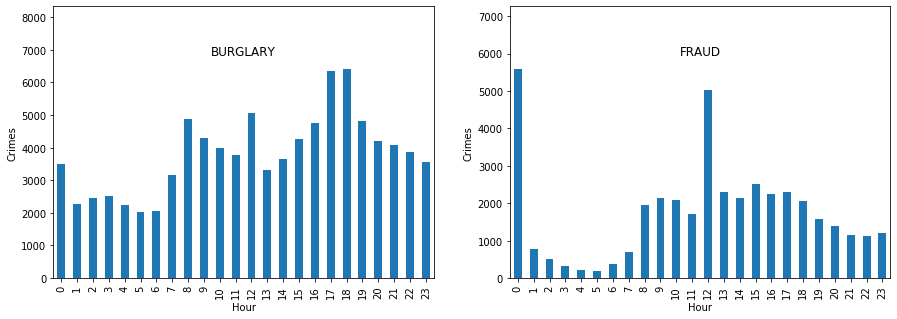

In [243]:
plot_feature(crimedata, "Hour", [crime1, crime2])

#### Hour of the week

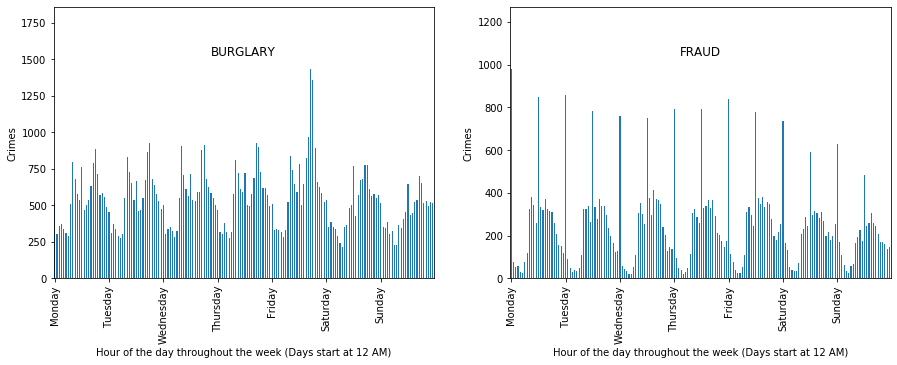

In [244]:
plot_feature(crimedata, "HourOfTheWeek", [crime1, crime2])

#### Day of the week

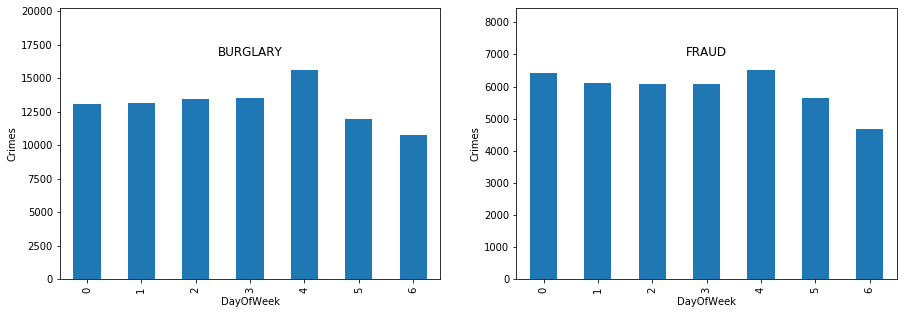

In [245]:
plot_feature(crimedata, "DayOfWeek", [crime1, crime2])

#### Month

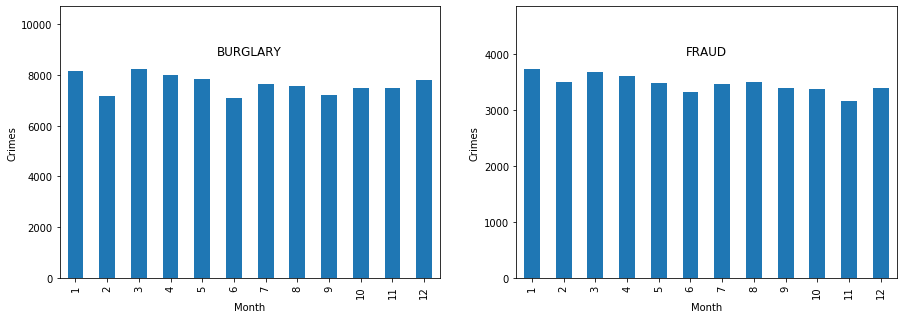

In [246]:
plot_feature(crimedata, "Month", [crime1, crime2])

#### PD District

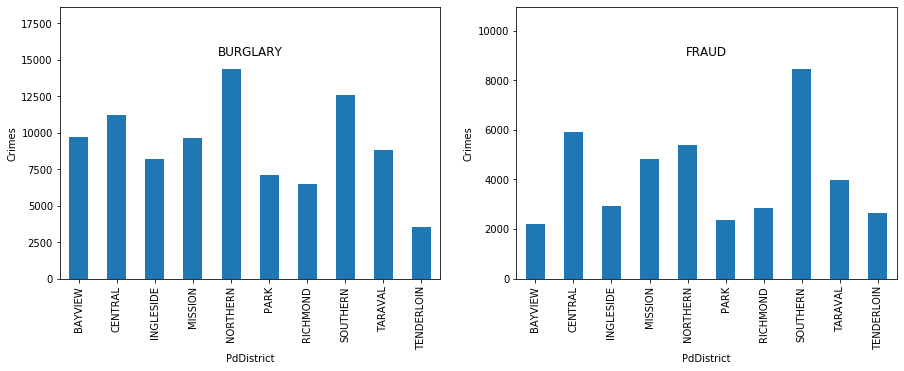

In [247]:
plot_feature(crimedata, "PdDistrict", [crime1, crime2])

#### Conclusions
From these informal visualizations we can conclude that the most informative features are HourOfTheWeek and Hour, along with PdDistrict that also shows some interesting differences for the two crimes as well. The other features show a similar patterns for both crimes and would not help the classifier in correctly predict the crimes.

### Fitting functions

In [271]:
#Sample balanced dataset
samplesizepercat = min(len(dtcrimedata[dtcrimedata.Category == crime1]),len(dtcrimedata[dtcrimedata.Category == crime2]))

crime1sample = dtcrimedata[dtcrimedata.Category == crime1].sample(n=samplesizepercat)
crime2sample = dtcrimedata[dtcrimedata.Category == crime2].sample(n=samplesizepercat)

balanceddataset = pd.concat([crime1sample, crime2sample])

In [345]:
def fit_and_predict(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=5, class_weight="balanced")
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    return y_test, y_predict

In [346]:
def fit_and_predict_training_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=5, class_weight="balanced")
    clf.fit(X_train, y_train)
    y_train_predict = clf.predict(X_train)
    return y_train, y_train_predict

In [307]:
def print_confusion_matrix(y_test, y_predict, crime1, crime2):
    cf_matrix = confusion_matrix(y_test, y_predict)
    labels = [f"True {crime1}",f"False {crime1}",f"False {crime2}",f"True {crime2}"]
    labels = np.asarray(labels).reshape(2,2)
    ax =  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

### Testing feature sets

#### We will try only the HourOfTheWeek along with PdDistrict

In [319]:
X = balanceddataset.drop(['Date', 'Hour', 'Category'], axis=1)
print(f"Columns used: {X.columns.values}")
y_test, y_predict = fit_and_predict(X, y)

Columns used: ['HourOfTheWeek' 'X' 'Y' 'pddistrict_BAYVIEW' 'pddistrict_CENTRAL'
 'pddistrict_INGLESIDE' 'pddistrict_MISSION' 'pddistrict_NORTHERN'
 'pddistrict_PARK' 'pddistrict_RICHMOND' 'pddistrict_SOUTHERN'
 'pddistrict_TARAVAL' 'pddistrict_TENDERLOIN']


[]

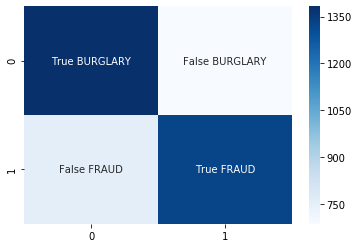

In [320]:
print_confusion_matrix(y_test, y_predict, crime1, crime2).plot()

In [321]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.65      0.67      0.66      2069
       FRAUD       0.66      0.64      0.65      2086

    accuracy                           0.65      4155
   macro avg       0.65      0.65      0.65      4155
weighted avg       0.65      0.65      0.65      4155



#### We will try Hour, HourOfTheWeek and PdDistrict features

In [322]:
X = balanceddataset.drop(['Date', 'Category'], axis=1)
print(f"Columns used: {X.columns.values}")
y_test, y_predict = fit_and_predict(X, y)

Columns used: ['Hour' 'HourOfTheWeek' 'X' 'Y' 'pddistrict_BAYVIEW' 'pddistrict_CENTRAL'
 'pddistrict_INGLESIDE' 'pddistrict_MISSION' 'pddistrict_NORTHERN'
 'pddistrict_PARK' 'pddistrict_RICHMOND' 'pddistrict_SOUTHERN'
 'pddistrict_TARAVAL' 'pddistrict_TENDERLOIN']


[]

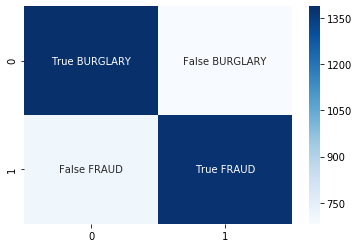

In [323]:
print_confusion_matrix(y_test, y_predict, crime1, crime2).plot()

In [326]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.66      0.67      0.67      2069
       FRAUD       0.67      0.66      0.66      2086

    accuracy                           0.66      4155
   macro avg       0.67      0.67      0.66      4155
weighted avg       0.67      0.66      0.66      4155



We will try only the **Hour** along with **PdDistrict**

In [316]:
y = balanceddataset.Category
X = balanceddataset.drop(['Date', 'HourOfTheWeek', 'Category'], axis=1)
print(f"Columns used: {X.columns.values}")
y_test, y_predict = fit_and_predict(X, y)

Columns used: ['Hour' 'X' 'Y' 'pddistrict_BAYVIEW' 'pddistrict_CENTRAL'
 'pddistrict_INGLESIDE' 'pddistrict_MISSION' 'pddistrict_NORTHERN'
 'pddistrict_PARK' 'pddistrict_RICHMOND' 'pddistrict_SOUTHERN'
 'pddistrict_TARAVAL' 'pddistrict_TENDERLOIN']


[]

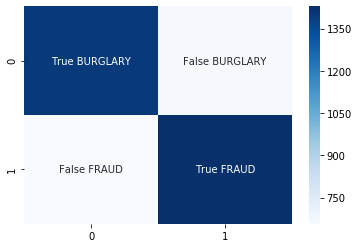

In [317]:
print_confusion_matrix(y_test, y_predict, crime1, crime2).plot()

In [318]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.68      0.68      0.68      2069
       FRAUD       0.68      0.69      0.68      2086

    accuracy                           0.68      4155
   macro avg       0.68      0.68      0.68      4155
weighted avg       0.68      0.68      0.68      4155



### Unbalanced dataset performance
Giving the optimal feature selection from the previous section, we test the perfomance on the unbalanced dataset

In [341]:
crime1sample = dtcrimedata[dtcrimedata.Category == crime1]
crime2sample = dtcrimedata[dtcrimedata.Category == crime2]

unbalanceddataset = pd.concat([crime1sample, crime2sample])

In [342]:
y = unbalanceddataset.Category
X = unbalanceddataset.drop(['Date', 'HourOfTheWeek', 'Category'], axis=1)
print(f"Columns used: {X.columns.values}")
y_test, y_predict = fit_and_predict(X, y)

Columns used: ['Hour' 'X' 'Y' 'pddistrict_BAYVIEW' 'pddistrict_CENTRAL'
 'pddistrict_INGLESIDE' 'pddistrict_MISSION' 'pddistrict_NORTHERN'
 'pddistrict_PARK' 'pddistrict_RICHMOND' 'pddistrict_SOUTHERN'
 'pddistrict_TARAVAL' 'pddistrict_TENDERLOIN']


[]

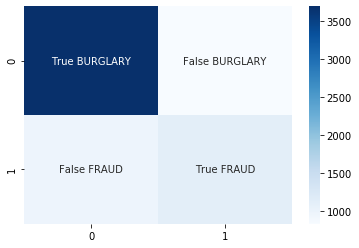

In [343]:
print_confusion_matrix(y_test, y_predict, crime1, crime2).plot()

In [344]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.79      0.82      0.80      4531
       FRAUD       0.58      0.53      0.55      2124

    accuracy                           0.73      6655
   macro avg       0.68      0.67      0.68      6655
weighted avg       0.72      0.73      0.72      6655



### Comments
#### Balanced dataset
As it can be seen in the previous section (**Unbalanced dataset performance**), the classifier trained on the unbalanced dataset predicts much better the most predominant category. This is due to the bigger proportion of observations in the dataset from that category - which leads to a more precise classifier (more data to learn from), and a general tendency for the model to predict many more new observations as belonging to that category since this will often be the right answer. We opted for a balanced dataset which provides almost the same classification result (f1 score among the others) for both categories. This way the classifier learns to classify the categories based on their differencies in behaviors and patterns rather than preferring one over the other due to a larger probability of guessing correctly.
#### Encoding
**PdDistrict** has been encoded into a one-hot encoding. This is due to its nature not having a ordinal relationship between values. One hot encoding solves this by creating a binary column for each value of that feature.
#### Features
From our initial visual comparison of the classification results with the different combinations of features - it looks like the combination of only the ****Hour**** feature along with ****PdDistrict**** and both ****X**** and ****Y**** coordinate is the one that gives the best performance.

#### Overfitting
In order to assess whether the classifier overfits the training set, we can compare the performance of the classifier on the training data and on the test data. Ideally we would get the same (high) prediction results on both the datasets.

In [352]:
# Extract X features and y column
y = balanceddataset.Category
X = balanceddataset.drop(['Date', 'HourOfTheWeek', 'Category'], axis=1)
print(f"Columns used: {X.columns.values}")

Columns used: ['Hour' 'X' 'Y' 'pddistrict_BAYVIEW' 'pddistrict_CENTRAL'
 'pddistrict_INGLESIDE' 'pddistrict_MISSION' 'pddistrict_NORTHERN'
 'pddistrict_PARK' 'pddistrict_RICHMOND' 'pddistrict_SOUTHERN'
 'pddistrict_TARAVAL' 'pddistrict_TENDERLOIN']


##### Results of prediction on training data

In [353]:
y_train, y_train_predict = fit_and_predict_training_data(X, y)
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

    BURGLARY       0.94      0.91      0.92     39473
       FRAUD       0.91      0.94      0.93     39456

    accuracy                           0.93     78929
   macro avg       0.93      0.93      0.93     78929
weighted avg       0.93      0.93      0.93     78929



##### Results of prediction on test data

In [354]:
y_test, y_predict = fit_and_predict(X, y)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    BURGLARY       0.66      0.68      0.67      2069
       FRAUD       0.67      0.66      0.67      2086

    accuracy                           0.67      4155
   macro avg       0.67      0.67      0.67      4155
weighted avg       0.67      0.67      0.67      4155



The results show a **possible overfitting**. This could be resolved by increasing the dataset size of with cross validation

## Part 2B: Info from weather features.
* Now add features from weather data to your random forest. 
  - Report accuracy. 
  - Discuss how the model performance changes relative to the version with no weather data.
  - Discuss what you have learned about crime from including weather data in your model.

## Part 3: Data visualization

* Create the Bokeh visualization from Part 2 of the Week 8 Lecture, displayed in a beautiful `.gif` below. 
* Provide nice comments for your code. Don't just use the `# inline comments`, but the full Notebook markdown capabilities and explain what you're doing.

![Movie](https://github.com/suneman/socialdataanalysis2020/blob/master/files/week8_1.gif?raw=true "movie")